In [1]:
#trying with sparse matrix
#from __future__ import division
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split,KFold
import  math 
from sklearn.neighbors import NearestNeighbors
import random
import time


start_time = time.time()
#Read csv file into dataframe
df=pd.read_csv("preprocessed_new_scaled_votes.csv",names=['user','Product','stars','votes'],nrows=100)

#Split the data into training 80% and testing 20%, run splitting 10 folds
no_folds=1
fold=0
RMSE=[]
for i in range(no_folds):
    print("***************************FOLD",fold,"*****************************************")
    training_data, test_data = train_test_split(df, test_size = 0.2)

    #compute the mean rating given by each user 
    mean_vote=training_data.groupby(['user'])['stars'].mean()
    print(mean_vote)

    #Creation of the training sparse matrix from dataframe
    user_u = list(sorted(training_data.user.unique()))
    item_u = list(sorted(training_data.Product.unique()))
    print("unique user, products", len(user_u),len(item_u))

    row_o = training_data.user.astype('category', categories=user_u).cat.codes
    col_o = training_data.Product.astype('category', categories=item_u).cat.codes
    data_o = training_data['stars'].tolist()
    sparse_matrix = csr_matrix((data_o, (row_o, col_o)), shape=(len(user_u), len(item_u)))
    #print(sparse_matrix,"\n*****************************************************\n")

    #Creation of the test sparse matrix from dataframe
    user_tu = list(sorted(test_data.user.unique()))
    item_tu = list(sorted(test_data.Product.unique()))


    row_t = test_data.user.astype('category', categories=user_tu).cat.codes
    col_t = test_data.Product.astype('category', categories=item_tu).cat.codes
    data_t = test_data['stars'].tolist()
    sparse_test = csr_matrix((data_t, (row_t, col_t)), shape=(len(user_tu), len(item_tu)))
    #print(sparse_test,"\n*****************************************************\n")

    #Computing the similarity values
    similarities = cosine_similarity(sparse_matrix,dense_output=False)
    #Preprocessing the votes
    df_votes=training_data['votes']
    votes=df_votes.values
    
    
    #Computing most similar neighbours to each user
    k = 6
    k=k+1   # because we dont want to consider similarity of neighbour with himself

    neighbours = []
    
    for a in range(len(user_u)):
        r = similarities.getrow(a)
            
        indices = r.indices
        data    = r.data
        n       = data.argsort()[-k:]
        n = n[:-1]

        for i in range(len(n)):
            n[i] = indices[n[i]]
    
        neighbours.append(n)


    #Computing mean square error
    square_sum =0
    count=0
    hits = 0


    for i,j in zip(user_tu,item_tu) :  
            if (i in user_u and j in item_u):

                        a = user_u.index(i)
                        b = item_u.index(j)
                        # Predicting only for those tuples which are in test data
                        x=0
                        y=0
                      
                        for u in neighbours[a]:
                            
                                x= x+(sparse_matrix[u,b]-mean_vote[u])*similarities[a,u]
                                y= y+similarities[a,u] 

                        d = 0
                        if y>0: 
                            d = (x/y)
                        p=math.ceil(mean_vote[a]+d)
                        if p>5:
                            p = 5
                        if p<0:
                            p = 0
                        count = count+1 

                        diff=sparse_test[user_tu.index(i),item_tu.index(j)]-p 
                        if diff==0:
                            hits = hits+1
                        square_sum=square_sum+pow(diff,2)  

    
    if count>0:
        RMSE.append(math.sqrt((square_sum/count)))
        accuracy = (hits/count)*100
        print("\nThe root mean square error is for fold: ",fold,"\t is:",RMSE)
        print("Accuracy",accuracy)
    else:
        print("no matches")
    fold=fold+1


#Computing average rmse over 10 folds
sum_rmse=0
avg_rmse=0
for i in range(len(RMSE)):
    sum_rmse=sum_rmse+RMSE[i]
avg_rmse= sum_rmse/len(RMSE)
print("\nThe Average root mean square of all folds is:",avg_rmse)

print("--- %s seconds ---" % (time.time() - start_time))



***************************FOLD 0 *****************************************
user
b'_-07hZmo--iEJ5brw72kXw'    5.000000
b'_-_IxATAvAxegPhTMnuQ8Q'    3.000000
b'_00XHr9on_5mWtaiYtdZjg'    4.750000
b'_00eJUs0SsGsiKu-WP6EEA'    5.000000
b'_00gcXhUeNsFsnA-HDXsbg'    1.000000
b'_01X4a-sS1Oc2yZuMMuCEQ'    4.636364
b'_04p87R3YdiUi9qqtfdXBQ'    5.000000
b'_059bXRkCzdOiEmPxZnUIA'    4.000000
b'_07T7_1xzJ-G9uAWRA_22A'    4.000000
b'_09ZrCQvLIiY2G3hMYcOSQ'    1.000000
b'_09pnhxUsyLr6jX07eJrTw'    4.000000
b'_0AlzcZa4vHSuOHcEbTeNg'    5.000000
b'_0aIuS6G8dFmZ8ao5zYkoA'    4.000000
b'_0aa5pFffDj7SrsyAAX7RQ'    1.000000
b'__26EDQ1FacBdY4gChHsuA'    3.750000
b'__FtIsjOxPkqiYfQedYgTg'    4.250000
b'__HoD7Xeu2NQwD_Gl98kaQ'    4.500000
b'__I3LlUs9mZ4vYEA91X-GA'    4.500000
b'__IH6IiLx8-V0KvEcn1u6g'    4.500000
b'__JmvLJkdl_n48eZCFa4Sg'    1.000000
b'__Mdh81qmNjbwgfr_jsu8A'    4.000000
b'__N7qbHbgF4xvqcTkiSrsQ'    4.000000
b'__NrG6DP0AZKpDlQ5drReg'    5.000000
b'__OEUOB6daDzs5AH4-kdFw'    4.000000
b'__PKD

In [13]:
# code to join the existing preprocessed data with the user votes data
import pandas as pd
df1=pd.read_csv("preprocessed.csv",names=['user','Product','stars'])
df2=pd.read_csv("votes.csv",names=['user','votes'])
df3=pd.merge(df1,df2,on='user',how='inner')
df3.to_csv('preprocessed_votes.csv')




In [33]:
from sklearn import preprocessing
import pandas as pd
#change this code
df=pd.read_csv("preprocessed_votes.csv",names=['user','Product','stars','votes'])
df=df['votes']
x = df.values #returns a numpy array

for i in range(len(x)):
    if x[i]>=0 and x[i]<400:
        x[i]=1
    elif x[i]>=400 and x[i]<1000:
        x[i]=2
    elif x[i]>=1000 and x[i]<5000:
        x[i]=3
    elif x[i]>=5000 and x[i]<10000:
        x[i]=4
    else:
        x[i]=5

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x)
df1 = pd.DataFrame(x_scaled)
df1.to_csv("votes_new_scaled.csv")



C:\Users\soumya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\soumya\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\soumya\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


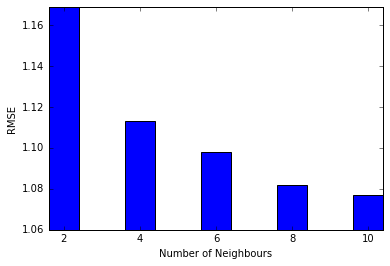

In [13]:
import pylab as plt
import math
%matplotlib inline

x = [2,4,6,8,10]
y = [1.169,1.113,1.098,1.082,1.077]
LABELS = ["2", "4", "6","8","10"]
plt.xticks(x, LABELS)
low = 1.060
high = max(y)
plt.ylim([low,high])
plt.bar(x, y, align='center')
plt.xlabel('Number of Neighbours')
plt.ylabel('RMSE')



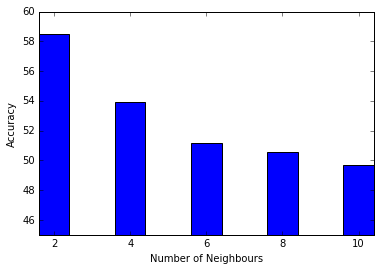

In [16]:
import pylab as plt
import math
%matplotlib inline

x=[2,4,6,8,10]
y=[58.49,53.93,51.17,50.55,49.66]
LABELS = ["2", "4", "6","8","10"]
plt.xticks(x, LABELS)
low = 45
high = 60
plt.ylim([low,high])
plt.bar(x, y, align='center')
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy')


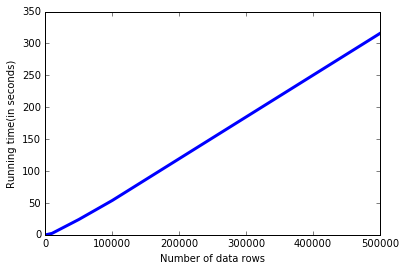

In [24]:
import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline
# #Running time vs the number of rows
# x=np.array([500000,100000,50000,10000,1000,500])
# y=np.array([315.955 ,53.899,24.057,2.296,0.125,0.0625])
# my_yticks=['0.0625','0.125','2.296','24.057','53.899','315.955']
# plt.yticks(y,my_yticks)
# plt.yticks(np.arange(y.min(), y.max(),200))
# plt.plot(x, y,linewidth=2.0)
# plt.xlabel('Number of data rows')
# plt.ylabel('Running time')



import pylab as plt
import math
%matplotlib inline

x=[500,1000,10000,50000,100000,500000]
y=[0.0625,0.125,2.296,24.056,53.899,315.955]
#LABELS = ["500", "1000", "10000","50000","100000","500000"]
#plt.xticks(x, LABELS)
low = 0.05
high = 350.00
plt.ylim([low,high])
plt.plot(x, y,linewidth=3)
plt.xlabel('Number of data rows')
plt.ylabel('Running time(in seconds)')

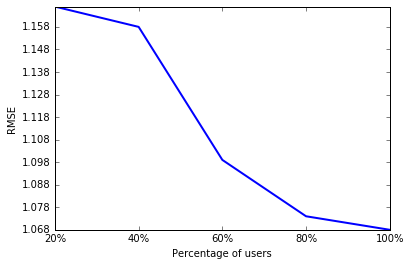

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = np.array([20,40,60,80,100])
y = np.array([1.167,1.158,1.099,1.074,1.068])
my_xticks = ['20%', '40%', '60%', '80%','100%']
plt.xticks(x, my_xticks)
plt.yticks(np.arange(y.min(), y.max(), 0.010))
plt.plot(x, y,linewidth=2.0)
plt.xlabel('Percentage of users')
plt.ylabel('RMSE')